## Setup: Imports & Dependencies

Run this cell once to load required libraries.

In [1]:
import time
import urllib
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Import helpers from the module (module keeps its own internal imports)
from notebook_utils import load_any_records, build_options_dataframe, build_option_views

# Configure plotting defaults
sns.set_theme(style='whitegrid', palette='Set2')
plt.rcParams['figure.figsize'] = (14, 6)

## Configuration

Edit these values to customize the analysis:
- **SERVER_URL**: The development server (e.g., `http://localhost:5173/`)
- **RULESET_NAME**: Which analysis ruleset to use
- **USER_EMAIL**: Your email for job submission
- **URLS**: List of websites to analyze for consent popups

In [2]:
# Server and analysis configuration
SERVER_URL = 'http://localhost:5173/'
RULESET_NAME = 'Scrape-O-Matic Data Gatherers'
USER_EMAIL = 'researcher@example.com'

# Websites to analyze
URLS = [
    'https://www.kleinanzeigen.de',
    'https://www.bild.de',
    'https://www.t-online.de',
    'https://web.de',
    'https://www.gmx.net',
    'https://www.otto.de',
    'https://www.spiegel.de',
    'https://www.idealo.de',
    'https://www.zalando.de',
    'https://www.wetter.com',
    'https://www.chefkoch.de',
    'https://www.focus.de',
    'https://www.welt.de',
    'https://www.n-tv.de',
    'https://www.tagesschau.de',
    'https://www.bahn.de',
    'https://www.kaufland.de',
    'https://www.lidl.de',
    'https://www.mediamarkt.de',
    'https://www.xing.com',
    'https://www.mobile.de',
    'https://www.immobilienscout24.de',
    'https://www.check24.de',
    'https://www.sparkasse.de',
    'https://www.postbank.de',
    'https://www.chip.de',
    'https://www.heise.de',
    'https://www.faz.net',
    'https://www.zeit.de',
    'https://www.sueddeutsche.de',
    'https://www.wetteronline.de',
    'https://www.kicker.de',
    'https://www.sport1.de',
    'https://www.computerbild.de',
    'https://www.stepstone.de',
    'https://www.holidaycheck.de',
    'https://www.lufthansa.com',
    'https://www.dhl.de',
    'https://www.deutschepost.de',
    'https://www.zdf.de',
    'https://www.ardmediathek.de',
    'https://www.stern.de',
    'https://www.bunte.de',
    'https://www.rossmann.de',
    'https://www.dm.de',
    'https://www.saturn.de',
    'https://www.obi.de',
    'https://www.hornbach.de',
    'https://www.tchibo.de',
    'https://www.thalia.de',
]

print(f'✓ Configured {len(URLS)} URLs for analysis')

✓ Configured 50 URLs for analysis


## Submission (Optional)

If you have a running consent-observatory server, this cell submits your URLs for analysis.
Otherwise, skip and load existing results from `examples/` or previous job files.

**Note**: The notebook will automatically fallback to example data if available.

In [3]:
submission_urls = globals().get('URLS_OVERRIDE', None) or URLS
submission_urls = list(submission_urls)

print(f'📤 Submitting {len(submission_urls)} URLs...')
print('Preview (first 5):')
for u in submission_urls[:5]:
    print(f'  • {u}')

# Use the helper in notebook_utils to submit and optionally wait for a completed zip
from notebook_utils import submit_urls_to_server
job_id, found_zip = submit_urls_to_server(SERVER_URL, submission_urls, USER_EMAIL, RULESET_NAME, timeout=240)
if job_id:
    print(f'✓ Job submitted with ID: {job_id}')
elif found_zip:
    print(f'✓ Found completed job: {found_zip} — loading results')
else:
    print('ℹ Submission complete; will load results from completed jobs or examples')

📤 Submitting 50 URLs...
Preview (first 5):
  • https://www.kleinanzeigen.de
  • https://www.bild.de
  • https://www.t-online.de
  • https://web.de
  • https://www.gmx.net
ℹ Submission complete; will load results from completed jobs or examples
ℹ Submission complete; will load results from completed jobs or examples


## Load Records

Load records from available sources in this order:
1. **In-memory `records` variable** (if you set it manually)
2. **`examples/data-example.zip`** (example data)
3. **`examples/*data*.json`** (example JSON files)
4. **`consent-observatory.eu/data/completed/`** (latest job results)

In [4]:
recs = load_any_records()

if not recs:
    print('⚠ No records found.')
    print('  Run the submission cell with a live server, or')
    print('  place an example zip in examples/data-example.zip')
else:
    print(f'✓ Loaded {len(recs)} records')

✓ Loaded 46 records


## Analysis: Overview

Build a wide table where each row is a website and columns show detected options categorized as:
- **accept**: "Accept all", "Agree", "Allow", "Consent"
- **reject**: "Reject", "Decline", "Deny"
- **reject_all**: "Reject all", "Decline all"
- **customize**: "Settings", "Preferences", "Manage", "Configure"
- **info**: "More info", "Learn more", "Why", "About"
- **confirm**: "Save", "Apply", "Confirm"
- **essential**: "Only necessary", "Essential only"
- **dismiss**: "Close", "Dismiss", "Got it"
- **other**: Noise-filtered uncategorized items

In [5]:
if recs:
    df_wide, df_long, summary_by_site, summary_overall = build_option_views(recs)
    print(f'✓ Analyzed {len(df_wide)} websites')
    print()
    print('=== OVERALL CATEGORY SUMMARY ===')
    print(summary_overall)
    print()
    # Calculate meaningful stats
    total_options = len(df_long)
    other_count = (df_long['category'] == 'other').sum()
    other_pct = (other_count / total_options * 100) if total_options > 0 else 0
    print(f'📊 Statistics:')
    print(f'   • Total options detected: {total_options}')
    print(f'   • Categorized (non-other): {total_options - other_count}')
    print(f'   • Uncategorized (other): {other_count} ({other_pct:.1f}%)')
    print()
    print('=== WEBSITE SUMMARY ===')
    # Select a set of sensible columns if available; fall back to first columns otherwise
    desired_cols = [
        'url', 'n_options',
        'has_accept', 'has_reject', 'has_reject_all', 'has_customize',
        'has_info', 'has_confirm', 'has_essential', 'has_dismiss',
    ]
    cols_to_show = [c for c in desired_cols if c in df_wide.columns]
    if not cols_to_show:
        # fallback to first few columns to avoid KeyError
        cols_to_show = list(df_wide.columns[:6])
    print(df_wide[cols_to_show].to_string(index=False))

✓ Analyzed 46 websites

=== OVERALL CATEGORY SUMMARY ===
category
accept         94
customize      59
dismiss        18
essential       3
info            5
other        1412
reject         28
Name: count, dtype: int64

📊 Statistics:
   • Total options detected: 1619
   • Categorized (non-other): 207
   • Uncategorized (other): 1412 (87.2%)

=== WEBSITE SUMMARY ===
                             url  n_options  has_accept  has_reject  has_reject_all  has_customize  has_info  has_confirm  has_essential  has_dismiss
             https://www.n-tv.de          9       False       False           False          False     False        False          False        False
    https://www.kleinanzeigen.de         11       False       False           False          False     False        False          False        False
                  https://web.de         15        True       False           False          False     False        False          False        False
       https://www.tagesschau.de 

## Visualization 1: Category Distribution

Stacked bar chart showing how many "accept", "reject", "settings", etc. options appear across websites.

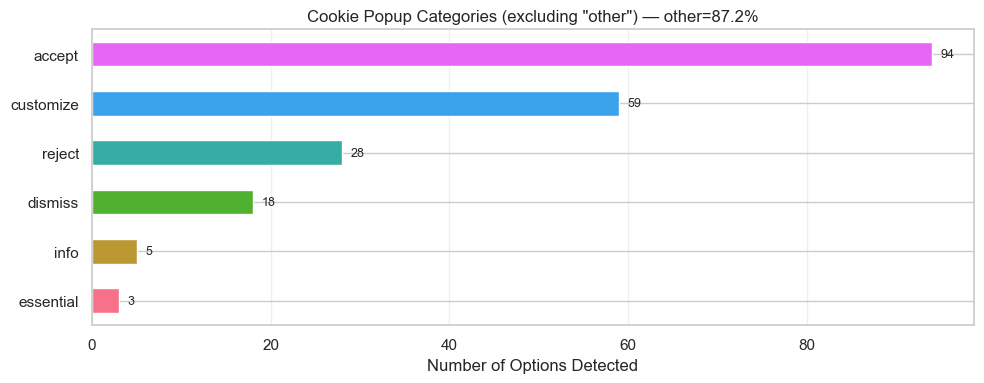


📌 "other" items: 1412 (87.2%) — top values:
    33  rgb(255, 255, 255)
    29  none solid rgb(255, 255, 255)
    28  rgba(0, 0, 0, 0)
    25  rgb(0, 0, 0)
    25  Lax
    25  14px
    22  1px
    22  international
    22  none solid rgb(0, 0, 0)
    18  false
    16  16px
    15  :root:iframe-content body
    14  de-at
    14  _sp_su
    13  12px
    12  Impressum
    10  ak_bmsc
    10  4px
     9  utag_main
     9  datenschutzerklärung



In [6]:
if recs and not df_long.empty:
    # Build counts and remove 'other' from the main display
    cat_counts = df_long['category'].value_counts()
    total = int(cat_counts.sum())
    other_count = int(cat_counts.get('other', 0))
    other_pct = (other_count / total * 100) if total else 0.0

    # Plot main categories excluding 'other' so small categories are legible
    cat_no_other = cat_counts.drop('other', errors='ignore').sort_values()
    if cat_no_other.empty:
        print('No categorized labels found (excluding "other").')
    else:
        n = len(cat_no_other)
        fig, ax = plt.subplots(figsize=(10, max(4, 0.4 * n)))
        colors = sns.color_palette('husl', n)
        cat_no_other.plot(kind='barh', ax=ax, color=colors)
        ax.set_title(f'Cookie Popup Categories (excluding "other") — other={other_pct:.1f}%')
        ax.set_xlabel('Number of Options Detected')
        ax.set_ylabel('')
        ax.grid(axis='x', alpha=0.3)
        max_v = cat_no_other.max() if cat_no_other.max() > 0 else 1
        for i, (label, v) in enumerate(cat_no_other.items()):
            ax.text(v + max_v * 0.01, i, str(int(v)), va='center', fontsize=9)
        plt.tight_layout()
        plt.show()

    # Drill-down: show the top items contained in 'other' (text output keeps the plot focused)
    if other_count > 0:
        print()
        print(f'📌 "other" items: {other_count} ({other_pct:.1f}%) — top values:')
        other_top = df_long[df_long['category'] == 'other']['option'].value_counts().head(20)
        for opt, v in other_top.items():
            print(f'   {v:3d}  {opt}')
    print()

## Visualization 2: Per-Site Category Heatmap

Heatmap showing which categories are present (yes/no) at each website.

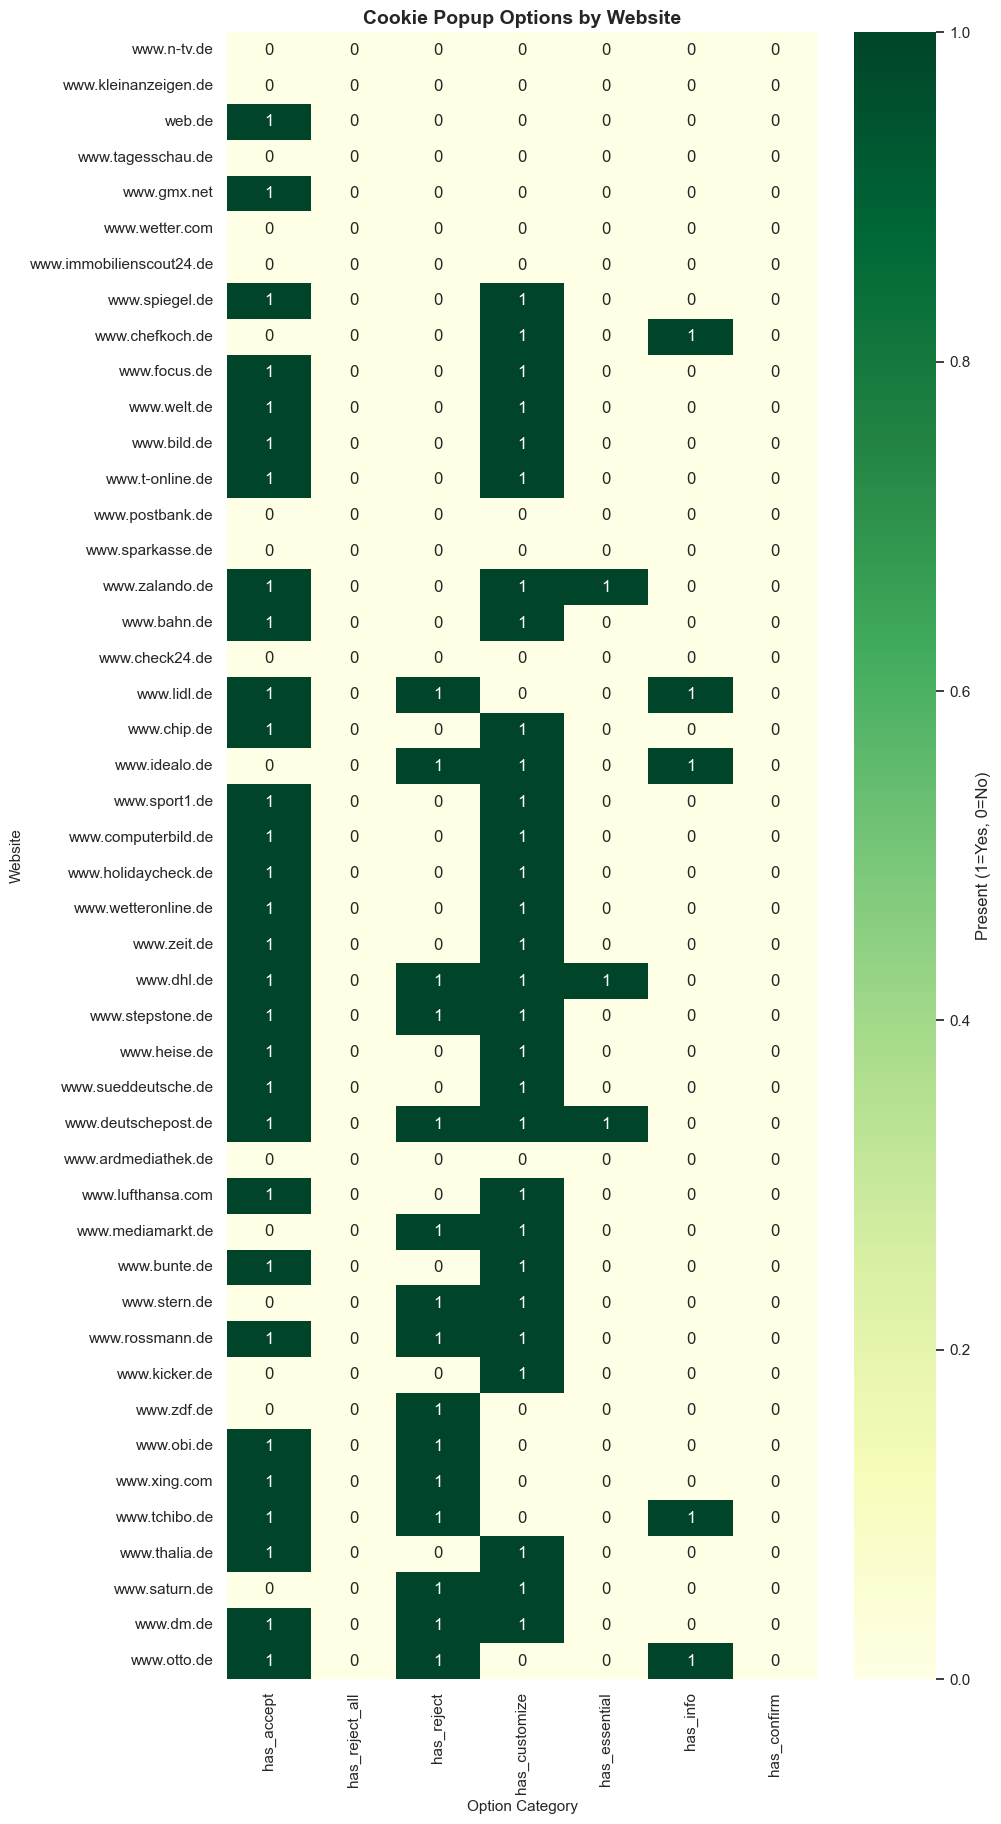

In [7]:
if recs and not df_wide.empty:
    fig, ax = plt.subplots(figsize=(10, max(6, len(df_wide) * 0.4)))
    heatmap_cols = ['has_accept', 'has_reject_all', 'has_reject', 'has_customize', 'has_essential', 'has_info', 'has_confirm']
    # use only existing columns for compatibility with older runs
    heatmap_cols = [c for c in heatmap_cols if c in df_wide.columns]
    heatmap_data = df_wide[heatmap_cols].astype(int)
    heatmap_data.index = [url.replace('https://', '').replace('http://', '') for url in df_wide['url']]
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGn', cbar_kws={'label': 'Present (1=Yes, 0=No)'}, ax=ax)
    ax.set_title('Cookie Popup Options by Website', fontsize=14, fontweight='bold')
    ax.set_xlabel('Option Category', fontsize=11)
    ax.set_ylabel('Website', fontsize=11)
    plt.tight_layout()
    plt.show()
    print()

## Visualization 3: Top Button Labels by Category

Bar charts showing the most common button texts in each category.

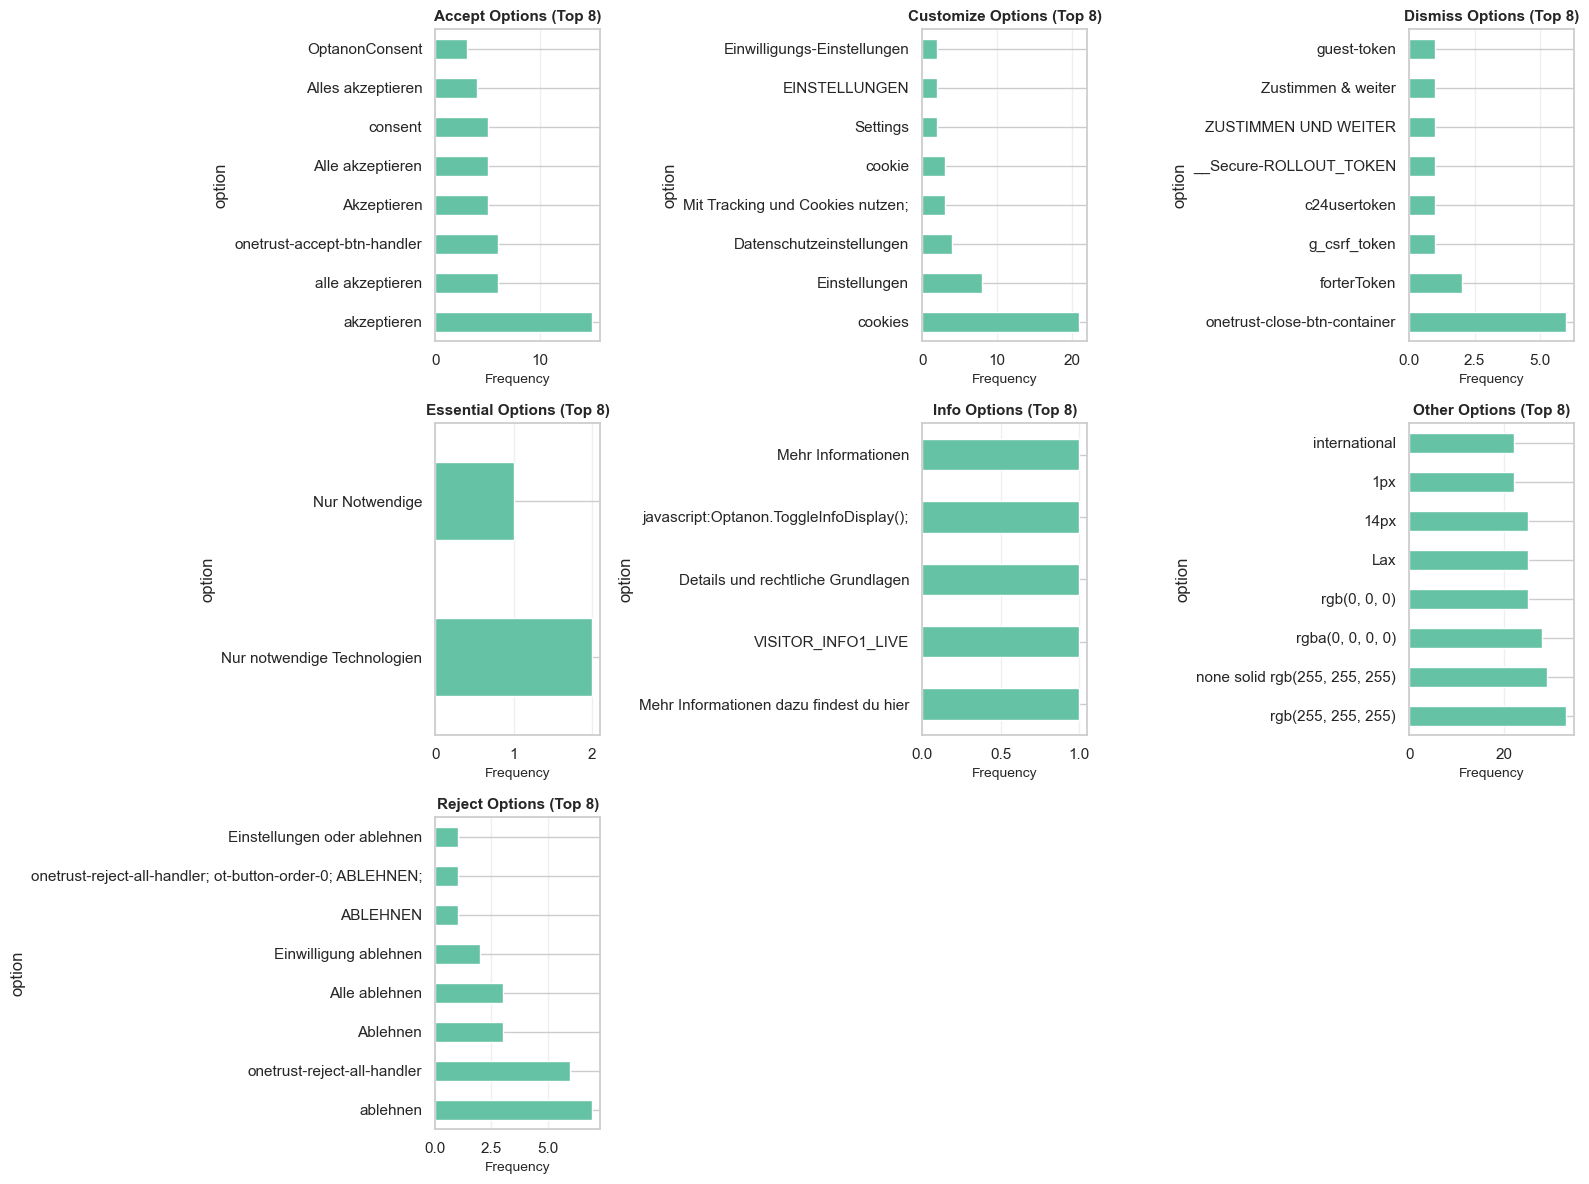

In [8]:
if recs and not df_long.empty:
    categories = sorted(df_long['category'].unique())
    n = len(categories)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, max(4*nrows, 6)))
    # flatten axes for easy indexing
    if hasattr(axes, 'flatten'):
        axes = axes.flatten()
    else:
        axes = [axes]
    for idx, cat in enumerate(categories):
        cat_options = df_long[df_long['category'] == cat]['option'].value_counts().head(8)
        ax = axes[idx]
        cat_options.plot(kind='barh', ax=ax, color=sns.color_palette('Set2', 1)[0])
        ax.set_title(f'{cat.title()} Options (Top 8)', fontsize=11, fontweight='bold')
        ax.set_xlabel('Frequency', fontsize=10)
        ax.grid(axis='x', alpha=0.3)
    # remove any unused subplots
    for idx in range(len(categories), len(axes)):
        try:
            axes[idx].remove()
        except Exception:
            pass
    plt.tight_layout()
    plt.show()
    print()

## Detailed Data: All Options by Category

Display all detected options grouped by their category.

In [9]:
if recs and not df_long.empty:
    for category in sorted(df_long['category'].unique()):
        options_in_cat = df_long[df_long['category'] == category]['option'].unique()
        print(f'📌 {category.upper()} ({len(options_in_cat)} unique)')
        for i, opt in enumerate(sorted(options_in_cat), 1):
            print(f'   {i:2d}. {opt}')
        print()

📌 ACCEPT (49 unique)
    1. AKZEPTIEREN UND WEITER
    2. ALLE AKZEPTIEREN
    3. Agree
    4. Agree and continue
    5. Akzeptieren
    6. Akzeptieren & Schließen
    7. Akzeptieren & Weiter
    8. Alle Cookies akzeptieren
    9. Alle akzeptieren
   10. Alles akzeptieren
   11. COOKIECONSENT
   12. Consent and continue
   13. I do not agree
   14. NO_CONSENT
   15. Nur technisch Erforderliches akzeptieren
   16. OptanonConsent
   17. agree
   18. akzeptieren
   19. alle akzeptieren
   20. btn btn--secondary js-accept-all-cookies; Allow all cookies;
   21. cm-acceptAll; button-primary; 0; Agree;
   22. consent
   23. consentUUID
   24. consent_ad_up_technology_ag
   25. consent_bing
   26. consent_deep_media_technologies_gmbh
   27. consent_facebook_custom_audience
   28. consent_facebook_pixel
   29. consent_ga_remarketing
   30. consent_google_ads
   31. consent_google_ads_remarketing
   32. consent_google_analytics
   33. consent_hotjar
   34. consent_pinterest
   35. consent_spotif